In [25]:
import pickle
import joblib

import pandas as pd

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import mean, std
from sklearn.model_selection import cross_val_score

In [26]:
path_to_data_folder =  '/Users/alexraudvee/Desktop/TU_e/year_2/Q3Y2_Process_Mining/process_mining_data'

In [28]:
# only for testing 
# total_rows = df_2017.shape[0]

# # Calculate the index to divide the DataFrame 
# split_index = total_rows // 2

# # Split the DataFrame into two halves
# df_2017 = df_2017.iloc[:split_index, :]

df_2017

,Unnamed: 0,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,...,time_to_next_event,time_to_next_event_seconds,predicted_time_to_next_event_seconds,elapsed_time_from_start,predicted_start_time,predicted_step,concept:name - lag_1,concept:name - lag_2,concept:name - lag_3,concept:name next
3,3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392,Existing loan takeover,New credit,...,0 days 00:00:00.011000,0.01,35.17,0 days 00:01:21.088000,5 days 16:10:11.014999397,W_Handle leads,W_Handle leads,A_Submitted,A_Create Application,W_Complete application
4,4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403,Existing loan takeover,New credit,...,0 days 00:00:00.010000,0.01,0.01,0 days 00:01:21.099000,5 days 08:22:12.629814592,W_Complete application,W_Handle leads,W_Handle leads,A_Submitted,A_Concept
5,5,statechange,User_1,A_Concept,Application,ApplState_642383566,complete,2016-01-01 09:52:36.413,Existing loan takeover,New credit,...,4 days 23:34:08.079000,430448.08,179447.74,0 days 00:01:21.109000,5 days 05:51:35.263530324,A_Concept,W_Complete application,W_Handle leads,W_Handle leads,A_Create Application
6,6,Created,User_1,A_Create Application,Application,Application_1691306052,complete,2016-01-01 10:16:11.500,Home improvement,New credit,...,0 days 00:00:00.049000,0.05,0.04,0 days 00:00:00,4 days 18:38:55.010316100,A_Create Application,A_Concept,W_Complete application,W_Handle leads,A_Submitted
7,7,statechange,User_1,A_Submitted,Application,ApplState_284636842,complete,2016-01-01 10:16:11.549,Home improvement,New credit,...,0 days 00:00:00.191000,0.19,0.30,0 days 00:00:00.049000,4 days 18:50:11.306445745,A_Submitted,A_Create Application,A_Concept,W_Complete application,W_Handle leads
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201084,1201084,statechange,User_99,A_Pending,Application,ApplState_1437687321,complete,2017-02-01 09:58:43.970,Remaining debt home,New credit,...,0 days 00:00:00.002000,0.00,0.00,75 days 14:18:05.736000,19 days 15:02:47.018194346,W_Call incomplete files,O_Accepted,W_Call incomplete files,A_Incomplete,W_Validate application
1201085,1201085,Deleted,User_99,W_Validate application,Workflow,Workitem_1690791617,ate_abort,2017-02-01 09:58:43.972,Remaining debt home,New credit,...,0 days 00:00:00.009000,0.01,0.02,75 days 14:18:05.738000,20 days 05:59:20.038348289,W_Call incomplete files,A_Pending,O_Accepted,W_Call incomplete files,O_Cancelled
1201086,1201086,statechange,User_99,O_Cancelled,Offer,OfferState_2080870299,complete,2017-02-01 09:58:43.981,Remaining debt home,New credit,...,0 days 00:00:00.007000,0.01,0.01,75 days 14:18:05.747000,20 days 07:06:36.925158626,W_Call incomplete files,W_Validate application,A_Pending,O_Accepted,O_Cancelled
1201087,1201087,statechange,User_99,O_Cancelled,Offer,OfferState_1140159487,complete,2017-02-01 09:58:43.988,Remaining debt home,New credit,...,0 days 00:00:00.006000,0.01,0.01,75 days 14:18:05.754000,20 days 04:04:09.814735216,W_Call incomplete files,O_Cancelled,W_Validate application,A_Pending,O_Cancelled


In [44]:
df_2017 = pd.read_csv('/Users/alexraudvee/Desktop/TU_e/year_2/Q3Y2_Process_Mining/BPI_2017_rfc_xgboost.csv')

In [45]:
df_2017.columns

Index(['Action', 'org:resource', 'concept:name', 'EventOrigin', 'EventID',
       'lifecycle:transition', 'time:timestamp', 'case:LoanGoal',
       'case:ApplicationType', 'case:concept:name', 'case:RequestedAmount',
       'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost',
       'Selected', 'CreditScore', 'OfferedAmount', 'OfferID',
       'time_to_next_event', 'time_to_next_event_baseline',
       'concept:name next', 'concept:name next rfc',
       'time_to_next_event_xgboost'],
      dtype='object')

In [30]:
# Prepare data
X = df_2017[['concept:name - lag_2', 'concept:name - lag_1', 'concept:name']]
y = df_2017['concept:name next']

# Use LabelEncoder to convert string labels to numerical values
label_encoder = LabelEncoder()
X['concept:name - lag_1'] = label_encoder.fit_transform(X['concept:name - lag_1'])
X['concept:name - lag_2'] = label_encoder.fit_transform(X['concept:name - lag_2'])
X['concept:name'] = label_encoder.fit_transform(X['concept:name'])
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the Random Forest Classifier
rf_clf = RandomForestClassifier(n_jobs=-1)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [21, 22, 23],
    'max_depth': [18, 19, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform nested cross-validation
outer_cv = KFold(n_splits=3, shuffle=False, random_state=None)  # 3-fold outer cross-validation
inner_cv = KFold(n_splits=5, shuffle=False, random_state=None)  # 5-fold inner cross-validation

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, scoring='accuracy', cv=inner_cv)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Print the results
print(f"Best params: {grid_search.best_params_}")
print(f'Nested Cross-Validation Accuracy: {grid_search.best_score_:.4f}')
print(best_model.score(X_test, y_test))


C:\Users\Nick Cornielje\AppData\Local\Temp\ipykernel_14852\2884791935.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['concept:name - lag_1'] = label_encoder.fit_transform(X['concept:name - lag_1'])
C:\Users\Nick Cornielje\AppData\Local\Temp\ipykernel_14852\2884791935.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['concept:name - lag_2'] = label_encoder.fit_transform(X['concept:name - lag_2'])
C:\Users\Nick Cornielje\AppData\Local\Temp\ipykernel_14852\2884791935.py:9: SettingWithCopyWarning: 
A

Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 21}
Nested Cross-Validation Accuracy: 0.8352
0.8362154376441399


In [31]:
df_2017['concept:name next rfc'] = label_encoder.inverse_transform(best_model.predict(X))

# decode labels

In [32]:
df_2017 = df_2017.drop(['concept:name - lag_1', 'concept:name - lag_2', 'concept:name - lag_3'], axis=1, errors='ignore')

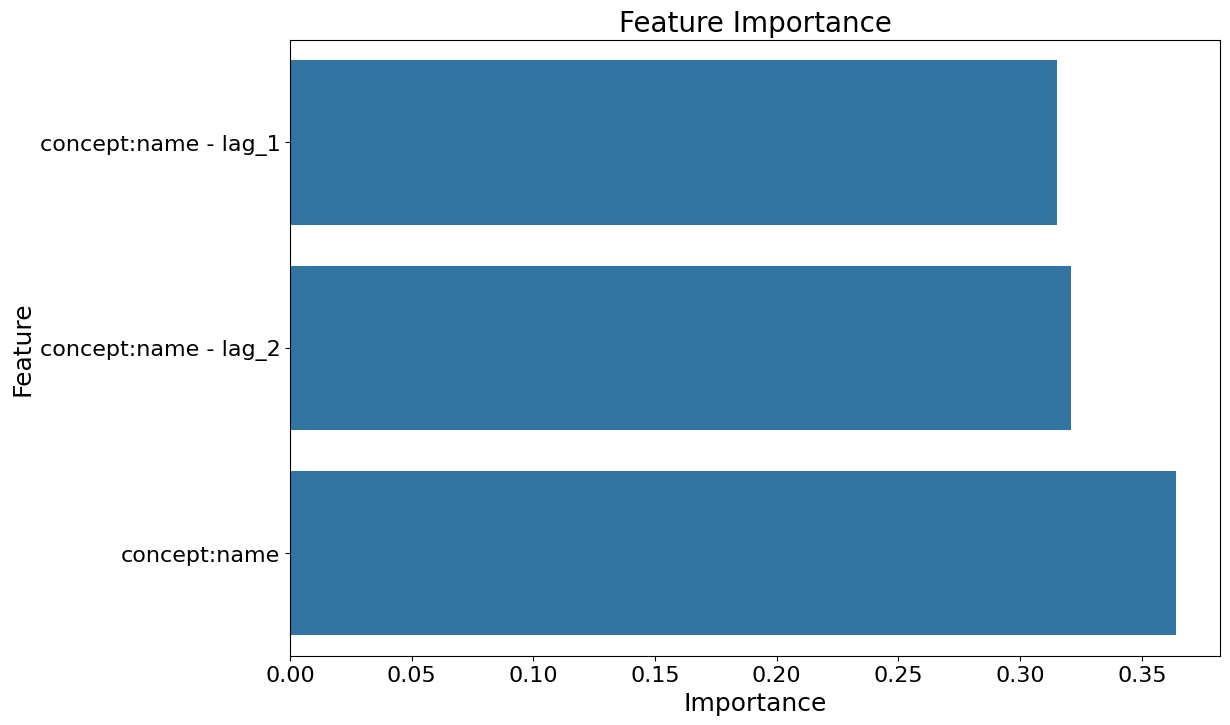

<Figure size 640x480 with 0 Axes>

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the importances into a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Plotting feature importances
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Importance', y='Feature', data=feature_importance_df)

plt.title('Feature Importance', fontsize=20)
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)

# Increase tick label size
barplot.xaxis.set_tick_params(labelsize=16)
barplot.yaxis.set_tick_params(labelsize=16)

plt.show()
plt.savefig('feature.png')

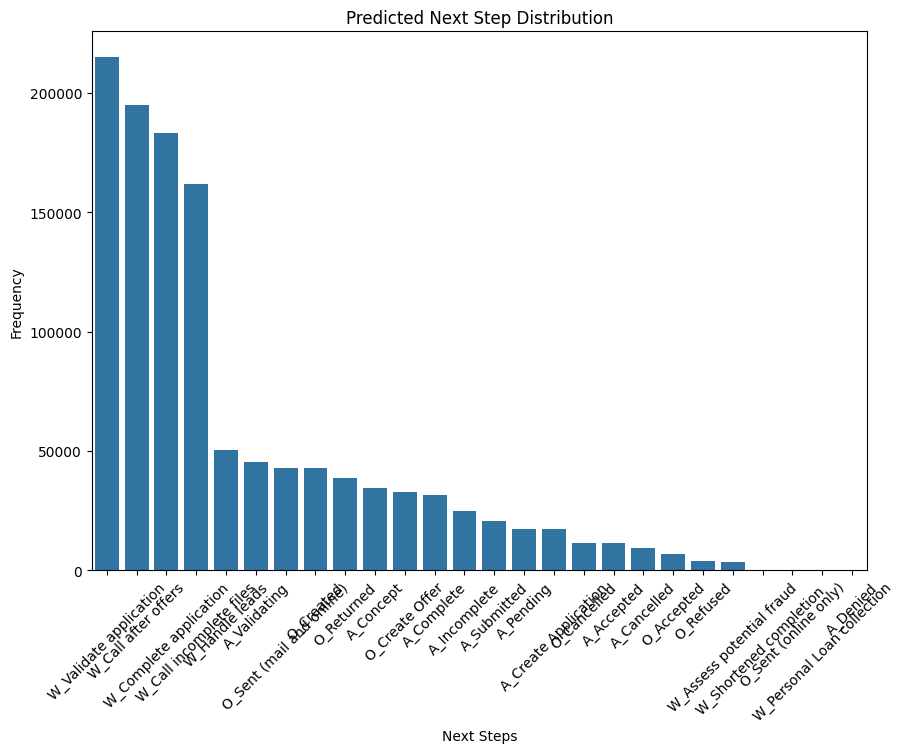

In [45]:

predicted_counts = df_2017['concept:name next rfc'].value_counts()

plt.figure(figsize=(10, 7))
sns.barplot(x=predicted_counts.index, y=predicted_counts.values)
plt.title('Predicted Next Step Distribution')
plt.xlabel('Next Steps')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [46]:
import matplotlib.pyplot as plt
import pandas as pd



# Calculate accuracy for each event_seq for the base case
accuracy_by_seq_base = df_2017.groupby('event_seq').apply(
    lambda x: (x['predicted_step'] == x['concept:name']).mean()).reset_index(name='accuracy_base')

# Calculate accuracy for each event_seq for the new model
accuracy_by_seq_new = df_2017.groupby('event_seq').apply(
    lambda x: (x['new_model_predicted_step'] == x['concept:name']).mean()).reset_index(name='accuracy_new')

# Merge the two accuracy DataFrames on 'event_seq'
accuracy_by_seq = pd.merge(accuracy_by_seq_base, accuracy_by_seq_new, on='event_seq')

# Plot accuracy over event_seq for both models
plt.figure(figsize=(12, 7))
plt.plot(accuracy_by_seq['event_seq'], accuracy_by_seq['accuracy_base'], marker='o', label='Base Case')
plt.plot(accuracy_by_seq['event_seq'], accuracy_by_seq['accuracy_new'], marker='x', label='New Model')
plt.xlabel('Event Sequence', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Prediction Accuracy Over Event Sequence', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


KeyError: 'event_seq'

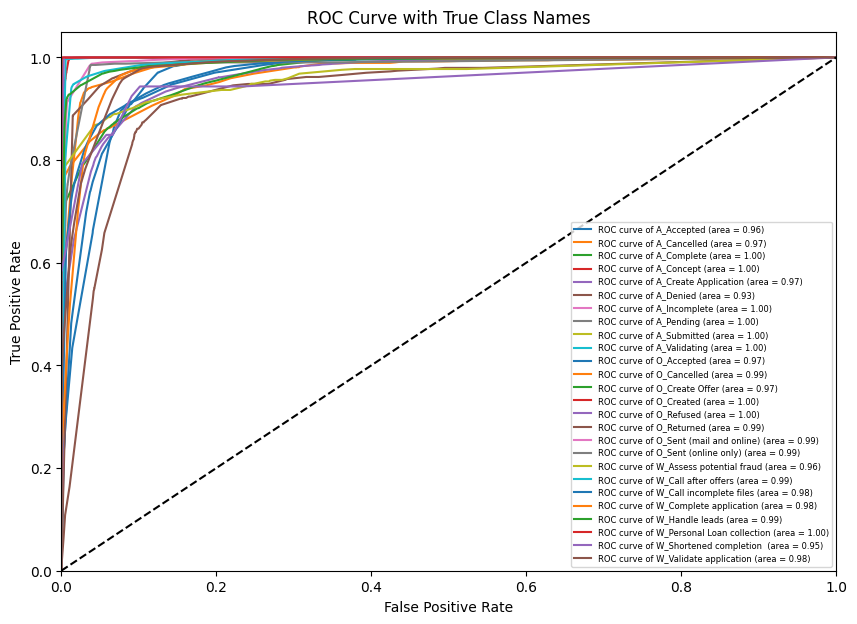

In [55]:
class_names = label_encoder.inverse_transform(range(n_classes))

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with True Class Names')
plt.legend(loc="lower right", prop={'size': 6})  # Adjust size as needed
plt.show()


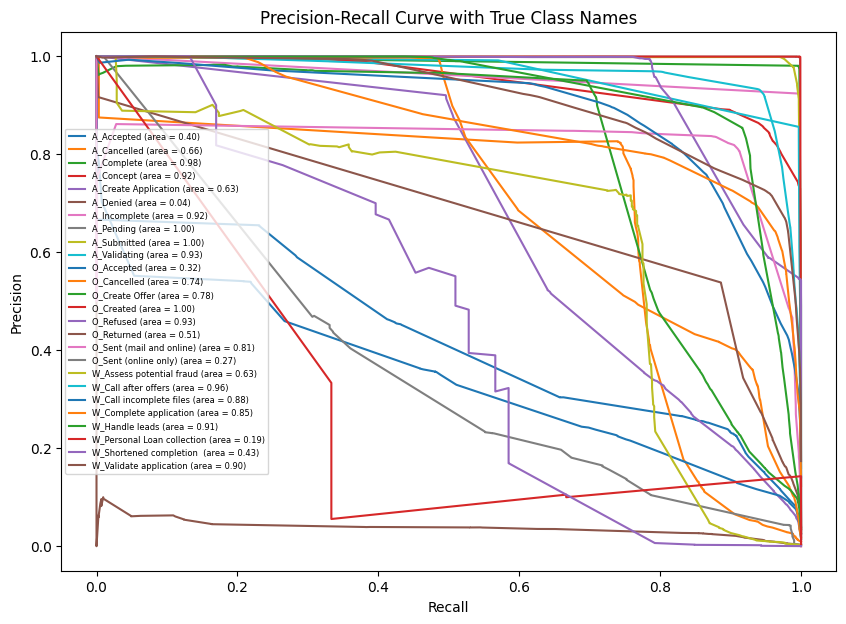

In [56]:
# Compute precision-recall curve and average precision for each class
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i],
                                                        y_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])

# Plotting
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} (area = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with True Class Names')
plt.legend(loc="best", prop={'size': 6})  # Adjust size as needed
plt.show()


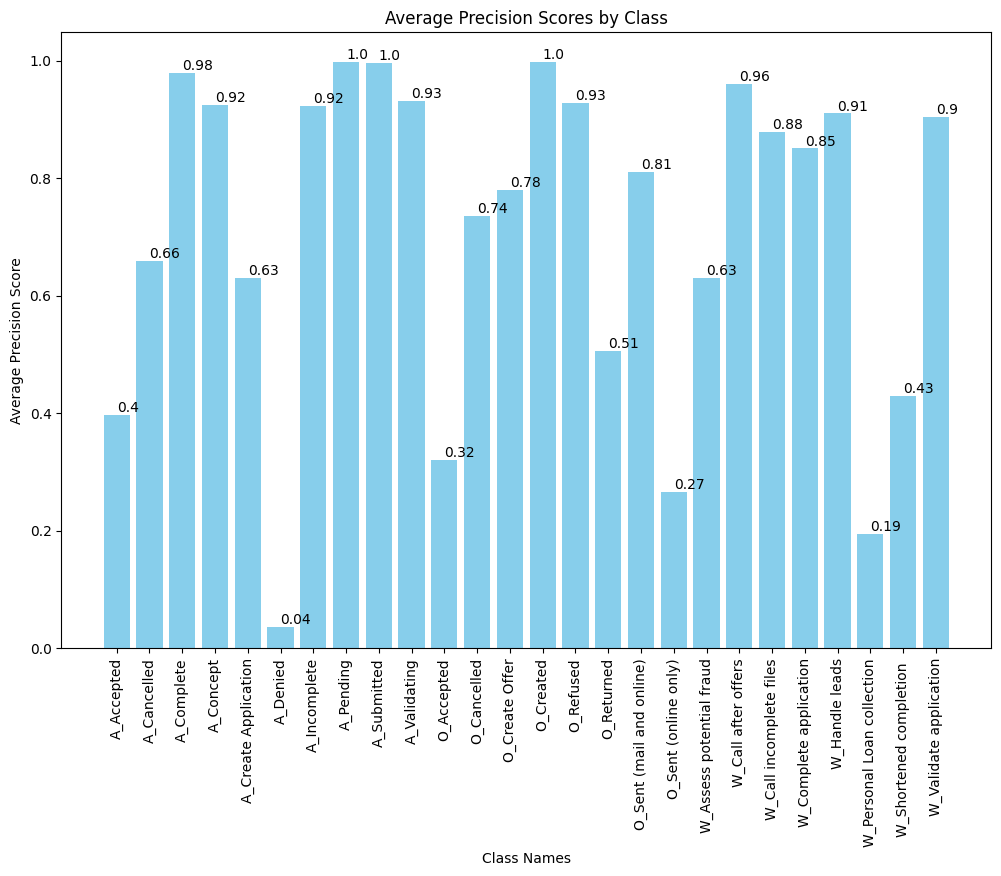

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Get class names from the label encoder
class_names = label_encoder.inverse_transform(sorted(average_precision.keys()))

# Get AP scores in the order of class names
ap_scores = [average_precision[i] for i in sorted(average_precision.keys())]

# Create a bar plot
plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(class_names)), ap_scores, color='skyblue')

# Add the AP scores above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  # va: vertical alignment

plt.xlabel('Class Names')
plt.ylabel('Average Precision Score')
plt.title('Average Precision Scores by Class')
plt.xticks(range(len(class_names)), class_names, rotation=90)  # Rotate class names for better visibility
plt.show()


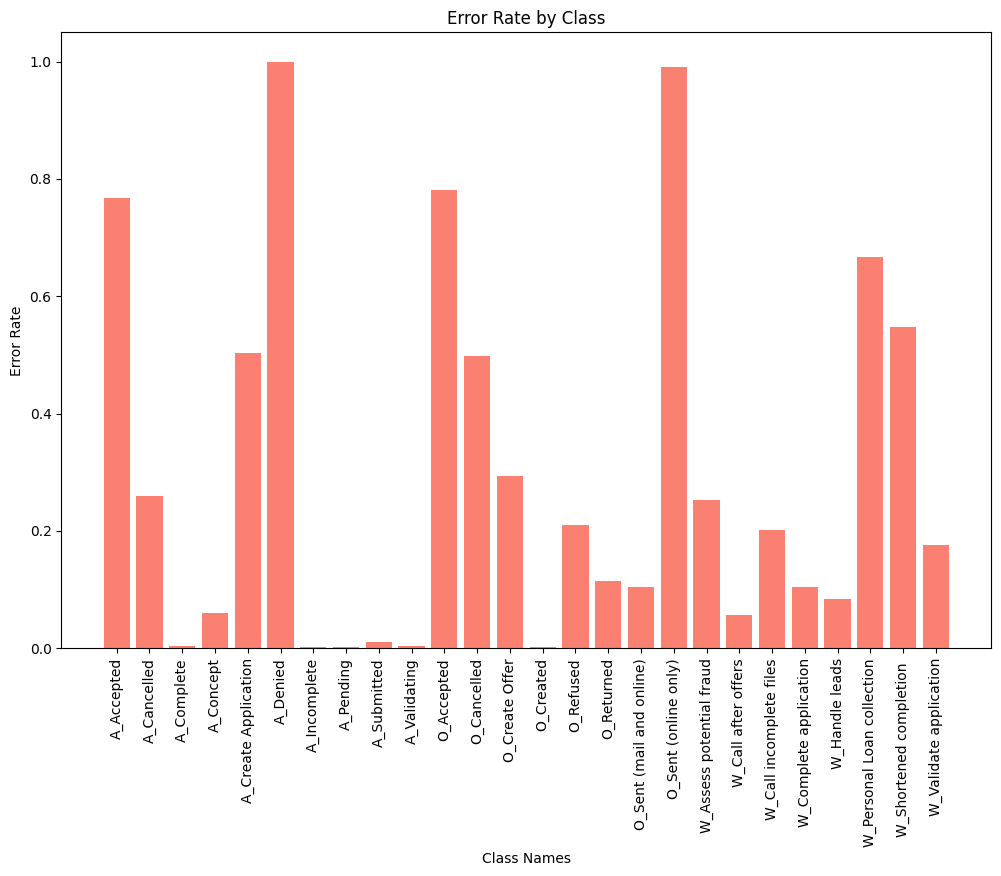

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

y_pred = best_model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Assuming 'label_encoder' is the LabelEncoder instance used to encode your labels
# Use the inverse transform method to get the original class names
class_names = label_encoder.inverse_transform(np.arange(cm.shape[0]))

# Calculate error rates for each class
error_rate = (cm.sum(axis=1) - np.diag(cm)) / cm.sum(axis=1)

# Plot the error rate by class
plt.figure(figsize=(12, 8))
plt.bar(class_names, error_rate, color='salmon')
plt.xlabel('Class Names')
plt.ylabel('Error Rate')
plt.title('Error Rate by Class')
plt.xticks(rotation=90)  # Rotate the class names for better readability if needed
plt.show()



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np


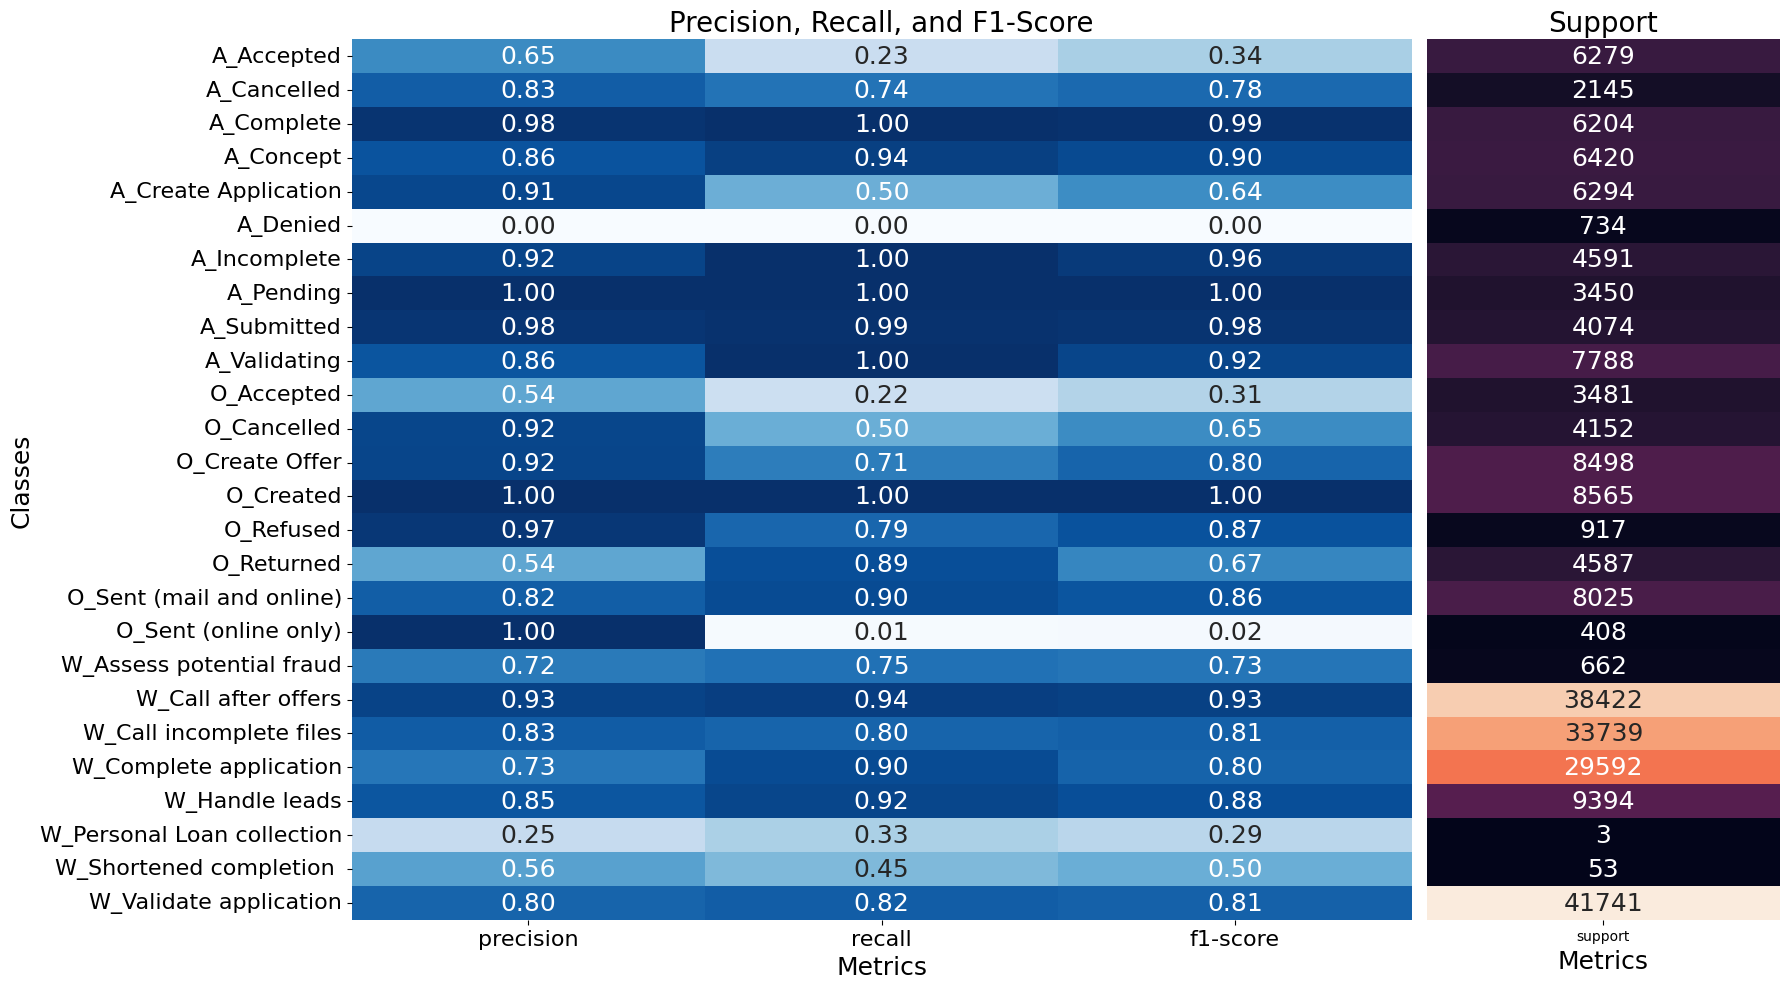

<Figure size 640x480 with 0 Axes>

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Generate the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Replace index with class names for clarity, using label_encoder
class_names = label_encoder.inverse_transform(sorted(np.unique(y_test)))

# Exclude the 'accuracy' row and split the DataFrame into metrics and support
metrics_df = report_df.iloc[:-3, :-1]  # Exclude the 'support' column and the last 3 summary rows
support_df = report_df.iloc[:-3, -1:].astype(int)  # Keep only the 'support' column, convert to int
metrics_df.index = class_names
support_df.index = class_names

# Setup the matplotlib figure and axes for a side-by-side plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [3, 1]})

# Plot the heatmap for metrics
sns.heatmap(metrics_df, annot=True, fmt=".2f", cmap='Blues', ax=ax1, cbar=False, annot_kws={'size':18})
ax1.set_title('Precision, Recall, and F1-Score', fontsize=20)
ax1.set_ylabel('Classes', fontsize=18)
ax1.set_xlabel('Metrics', fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=16)

# Plot the heatmap (actually just annotated cells) for support
sns.heatmap(support_df, annot=True, fmt="d", cmap=None, ax=ax2, cbar=False, annot_kws={'size':18})
ax2.set_title('Support', fontsize=20)
ax2.set_xlabel('Metrics', fontsize=18)
ax2.tick_params(axis='y', which='major', labelsize=16)
ax2.set_yticks([]) 

plt.tight_layout()
plt.show()
plt.savefig('Precision_recall_F1_support_scores.jpg')

In [34]:
df_2017.to_csv('BPI_2017_rfc_xgboost.csv')

In [35]:
# Save the best model to a file
model_filename = 'random_forest_model.joblib'
joblib.dump(best_model, model_filename)

# Save the best model to a file using pickle
model_filename = 'random_forest_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(best_model, model_file)

### Only for test purposes, do not run it

In [36]:
# create dataset
X = df_2017[['concept:name - lag_2', 'concept:name - lag_1', 'concept:name']]
y = df_2017[['concept:name next']]

# Use LabelEncoder to convert string labels to numerical values
label_encoder = LabelEncoder()
X['concept:name - lag_1'] = label_encoder.fit_transform(X['concept:name - lag_1'])
X['concept:name - lag_2'] = label_encoder.fit_transform(X['concept:name - lag_2'])
X['concept:name'] = label_encoder.fit_transform(X['concept:name'])
y = label_encoder.fit_transform(y)

# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=False, random_state=None)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X):
    # split data
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=3, shuffle=False, random_state=None)
    # define the model
    model = RandomForestClassifier(n_jobs=1)
    # define search
    search = GridSearchCV(model, param_grid=param_grid, scoring='accuracy', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

KeyError: "['concept:name - lag_2', 'concept:name - lag_1'] not in index"

In [ ]:
# Save the best model to a file
model_filename = 'random_forest_model.joblib'
joblib.dump(best_model, model_filename)

# Save the best model to a file using pickle
model_filename = 'random_forest_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(best_model, model_file)

In [ ]:
df_2017

,Unnamed: 0,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,...,predicted_time_to_next_event_seconds,elapsed_time_from_start,predicted_start_time,predicted_step,predicted_time_to_next_event_seconds_XG,concept:name - lag_1,concept:name - lag_2,concept:name - lag_3,concept:name next,predicted_next_event_rfc
3,3.0,1,0,22,2,701704,6,3,5,1,...,0 days 00:00:35.170000,33119,128,7,0 days 00:00:15,22.0,8.0,4.0,21.0,21
4,4.0,0,0,21,2,630431,3,4,5,1,...,0 days 00:00:00.010000,33126,127,6,0 days 00:00:05.500000,22.0,22.0,8.0,3.0,3
5,5.0,4,0,3,0,169679,1,5,5,1,...,2 days 01:50:47.740000,33133,126,0,4 days 22:54:39.812500,21.0,22.0,22.0,4.0,4
6,6.0,0,0,4,0,219156,1,6,7,1,...,0 days 00:00:00.040000,0,112,1,0 days 00:00:53.700001,3.0,21.0,22.0,8.0,8
7,7.0,4,0,8,0,130913,1,7,7,1,...,0 days 00:00:00.300000,49,113,3,0 days 00:00:11.200000,4.0,3.0,21.0,22.0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201085,1201085.0,1,148,25,2,708416,0,1200970,11,1,...,0 days 00:00:00.020000,999899,44,5,0 days 00:01:00.799999,7.0,10.0,20.0,11.0,25
1201086,1201086.0,4,148,11,1,323681,1,1200971,11,1,...,0 days 00:00:00.010000,999900,45,5,0 days 00:01:17.500000,25.0,7.0,10.0,11.0,25
1201087,1201087.0,4,148,11,1,250417,1,1200972,11,1,...,0 days 00:00:00.010000,999901,43,5,0 days 00:01:17.500000,11.0,25.0,7.0,11.0,25
1201088,1201088.0,4,148,11,1,316489,1,1200973,11,1,...,0 days 00:00:00.010000,999902,47,5,0 days 00:01:17.500000,11.0,11.0,25.0,11.0,19
